CNN LSTM 

Data Set 14
Using data zero data zero padding


In [1]:
%load_ext tensorboard
import tensorflow as tf
import datetime
import keras

import numpy as np
import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Input ,Dense, Dropout, Activation, LSTM, Conv1D
from keras.layers import Lambda, Convolution1D, MaxPooling1D, Flatten, Reshape, BatchNormalization
from keras.layers.wrappers import TimeDistributed
from keras.layers.pooling import GlobalAveragePooling1D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.metrics import categorical_crossentropy, binary_crossentropy

#from spp.SpatialPyramidPooling import SpatialPyramidPooling

#For data saving
import pickle
import random
#other imports
import gzip
import glob
import os
import keras.backend as K
import os
import time 
#cwd = os.path.dirname(os.path.realpath("SURF_001_TwoClass13.ipynb"))

In [2]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

!rm -rf ./logs/ 

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
genome = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']

**Creating Dataframe**

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [ ]:
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(1000, 4), n_channels=0,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, 1000, 4))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('../model_11_data_4/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [4]:
dense_layer = 1
layer_size = 64 
conv_layer = 2
seq_length = 1000
base_pair = 4
num_strides = 1
pool_size = 4

In [ ]:
test_count = 0
with open('../partition_train_val_a.dat', 'rb') as f:
    partition = pickle.load(f)
for index in partition['train']:
    a = partition['labels'][index][0][0]
    if test_count < 10:
        print(a)
    partition['labels'][index] = a
    test_count += 1
    if test_count < 10:
        print(partition['labels'][index])
for index in partition['validation']:
    a = partition['labels'][index][0][0]
    partition['labels'][index] = a
    test_count += 1
    if test_count < 20:
        print(partition['labels'][index])


In [ ]:
cat_1 = 0
cat_0 = 0
for i in partition['train']:
    if partition['labels'][i] == 0:
        cat_0 += 1
    elif partition['labels'][i] == 1:
        cat_1 += 1
    else:
        print('issue')

In [ ]:
print(cat_1)
print(cat_0)

In [ ]:
# Parameters
params = {'dim': (32,1000,4),
          'batch_size': 64,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}

# Datasets
#with open('../partition_train_val_a.dat', 'rb') as f:
   # partition = pickle.load(f)

labels = partition['labels']

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Design model
model = Sequential()
model.add(Conv1D(filters=layer_size, kernel_size=(4), input_shape=(seq_length, 4), activation='relu', strides=1, padding='valid'))
model.add(Conv1D(layer_size, 4, batch_input_shape=(32, seq_length, 4), strides=1, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=4, strides=None, padding='valid', data_format='channels_last'))
model.add(Dropout(0.1, noise_shape=None, seed=None))

model.add(Flatten())

model.add(Dense(12))
model.add(Activation('relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

# Train model on dataset
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=False)

In [5]:
with open('../partition_train_val_a.dat', 'rb') as f:
    partition = pickle.load(f)
train_samples = partition['train']
val_samples = partition['validation']
random.shuffle(train_samples)
random.shuffle(val_samples)

labels = partition['labels']
partition['train'] = train_samples
partition['validation'] = val_samples

print(len(train_samples))
for ID in train_samples:
    if labels[ID][0][0] == 0:
        train_samples.remove(ID)
print(len(train_samples))
print(labels[train_samples[0]])

print(len(val_samples))
for ID in val_samples:
    if labels[ID][0][0] == 0:
        val_samples.remove(ID)
print(len(val_samples))
print(labels[val_samples[0]])


'''
a = partition['train'][0]
print(a)
print(partition['labels'][a] )
train_labels = np.empty(1, dtype=np.int8)
train_samples = []
train_labels[0] = partition['labels'][a] 
train_samples = np.load('../model_11_data_4/' + partition['train'][0] + '.npy')


print(train_labels.shape)
print(train_samples.shape)


val_labels = train_labels
val_samples = train_samples
print(val_labels.shape)
print(val_samples.shape)
'''



# Parameters
params = {'dim': (32,1000,4),
          'batch_size': 64,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}

# Datasets
#with open('../partition_train_val_a.dat', 'rb') as f:
   # partition = pickle.load(f)


# Generators
#training_generator = DataGenerator(partition['train'], labels, **params)
#validation_generator = DataGenerator(partition['validation'], labels, **params)

dense_layers = [1]
layer_sizes = [64, 128]
conv_layers = [1]

# Design model
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            Earlystop = EarlyStopping(
            monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto',
            baseline=None, restore_best_weights=True)
            count_input_train = 0
            count_input_validation = 0
            while count_input_train < len(partition['train']):
                Y_train = np.zeros((200, 2), dtype=np.int8)
                X_train = np.zeros((200, 1000, 4), dtype=np.int8)
                Y_val = np.zeros((40, 2), dtype=np.int8)
                X_val = np.zeros((40, 1000, 4), dtype=np.int8)
                if count_input_train < (len(train_samples) - 200):
                    for i in range(0, 200):
                        a = train_samples[count_input_train]
                        X_train[i, :, :] = np.load('../model_11_data_4/' + train_samples[count_input_train] + '.npy') 
                        Y_train[i, :] = partition['labels'][a] 
                        count_input_train += 1
                else:
                    count_input_train += 1000
                if count_input_validation < (len(partition['validation']) - 40):
                    for i in range(0, 40):
                        a = partition['validation'][count_input_validation]
                        X_val[i, :, :] = np.load('../model_11_data_4/' + partition['validation'][count_input_validation] + '.npy') 
                        Y_val[i, :] = partition['labels'][a] 
                        count_input_validation += 1

                model = Sequential()
                model.add(Conv1D(filters=layer_size, kernel_size=(4), input_shape=(seq_length, 4), activation='relu', strides=1, padding='valid'))
                model.add(MaxPooling1D(pool_size=4, strides=None, padding='valid', data_format='channels_last'))
                model.add(Conv1D(layer_size, 4, batch_input_shape=(1, seq_length, 4), strides=1, padding='valid', activation='relu'))
                model.add(MaxPooling1D(pool_size=4, strides=None, padding='valid', data_format='channels_last'))

                model.add(Dropout(0.01, noise_shape=None, seed=None))
                model.add(Conv1D(layer_size, 4, batch_input_shape=(1, seq_length, 4), strides=1, padding='valid', activation='relu'))
                model.add(MaxPooling1D(pool_size=4, strides=None, padding='valid', data_format='channels_last'))

                model.add(Dropout(0.01, noise_shape=None, seed=None))
                model.add(Conv1D(layer_size, 4, batch_input_shape=(1, seq_length, 4), strides=1, padding='valid', activation='relu'))
                model.add(MaxPooling1D(pool_size=4, strides=None, padding='valid', data_format='channels_last'))

                model.add(Dropout(0.01, noise_shape=None, seed=None))

                for l in range(conv_layer-1):
                    model.add(MaxPooling1D(pool_size=4, strides=None, padding='valid', data_format='channels_last'))
                    model.add(Conv1D(layer_size, 4, activation='relu'))

                #model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid', data_format='channels_last'))
                #model.add(Conv1D(64, 4, activation='relu'))

                model.add(Dropout(0.1, noise_shape=None, seed=None))

                model.add(LSTM(128))

                model.add(Flatten())
                
                model.add(Dense(512))
                model.add(Activation("relu"))
                model.add(Dropout(0.01))
                model.add(Dense(512))
                model.add(Activation("relu"))
                model.add(Dropout(0.01))

                for l in range(dense_layer):
                    model.add(Dense(128))
                    model.add(Activation('relu'))
                model.add(Dense(2, activation='softmax'))
                
                opt = keras.optimizers.Adam(learning_rate=0.001)


               # optimizer = keras.optimizers.Adam(lr=0.00001)
                model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
                if count_input_train < 400:
                    print(model.summary())
                    model.save('../Models_H5/011_{}-conv-{}-nodes-{}-dense-{}CNNLSTM'.format(conv_layer, layer_size, dense_layer, int(time.time())))
                                # Train model on dataset
                model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=500, callbacks=[Earlystop], verbose=2)



54082
35250
[[1 0]]
13520
8761
[[0 1]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 997, 64)           1088      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 249, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 246, 64)           16448     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 61, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 61, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 58, 64)            16448     
_________________________________________________________________
max_pooling1d_2 (

KeyboardInterrupt: 

In [ ]:
#Testing which model I'll pick


In [42]:
with open('../partition_train_val_a.dat', 'rb') as f:
    partition = pickle.load(f)
train_samples_IDs = partition['train']
val_samples_IDs = partition['validation']
IDs = partition['labels']

In [43]:
model = load_model('../Models_H5/011_{}-conv-{}-nodes-{}-dense-{}CNNLSTM'.format(1, 128, 1, 1601188309))

In [44]:
predicted = []
Y_val_expected = []
count_input_val = 0
num_val_seq = len(partition['validation'])
done = False
while count_input_val < num_val_seq and not(done):
    X_val = np.zeros((200, 1000, 4), dtype=np.int8)
    if count_input_val < (num_val_seq - 200):
        for i in range(0, 200):
            a = partition['validation'][count_input_val]
            X_val[i, :, :] = np.load('../model_11_data_4/' + partition['validation'][count_input_val] + '.npy') 
            count_input_val += 1
        predict = (model.predict_classes(X_val))
        for label in predict:
            predicted.append(label)
    else:
        done = True
    if count_input_val == 16200:
        done = True
    print(count_input_val)
print(len(predicted))
print(predicted[0])

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13400
13400
0


In [45]:
expected = []

for label in val_samples_IDs:
    expected.append(IDs[label][0][0])
print(expected[0])
print(len(expected))


1
13520


In [46]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
 
results = confusion_matrix(expected[0:13400], predicted)
print(results)
# Printing the precision and recall, among other metrics
#print(metrics.classification_report(y_act, y_pred, labels=["a", 
#"b"]))

[[1779 5420]
 [1498 4703]]


<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000019CB7867040>>


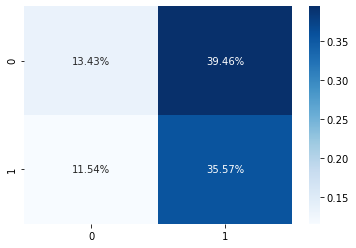

In [53]:
import seaborn as sns

sns.heatmap(results/np.sum(results), annot=True, 
            fmt='.2%', cmap='Blues')
print(model.summary)

In [ ]:
### HERE 1

Extra Code:


In [54]:
with open('../partition_test_a.dat', 'rb') as f:
    partition = pickle.load(f)
test_samples_IDs = partition['test']

with open('../test_labels.dat', 'rb') as f:
    test_labels = pickle.load(f)
print(len(test_labels))


16382


In [55]:
model = load_model('../Models_H5/SURF_Paper_9.26.20/011_{}-conv-{}-nodes-{}-dense-{}CNNLSTM-9-26-20'.format(1, 64, 0, 1601093561))

In [56]:
predicted = []
count_input_test = 0
num_test_seq = len(partition['test'])
done = False
while count_input_test < num_test_seq and not(done):
    X_test = np.zeros((200, 1000, 4), dtype=np.int8)
    if count_input_test < (num_test_seq - 200):
        for i in range(0, 200):
            a = partition['test'][count_input_test]
            X_test[i, :, :] = np.load('../DataSet_14_Test_2/' + partition['test'][count_input_test] + '.npy') 
            count_input_test += 1
        predict = (model.predict_classes(X_test))
        for label in predict:
            predicted.append(label)
    else:
        done = True
    if count_input_test == 16200:
        done = True
    print(count_input_test)
print(len(predicted))
print(len(test_labels))
print(predicted[0])

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16200
16382
1


In [57]:
expected = []
for label in test_labels[0:16200]:
    expected.append(label[0][0])
print(expected[0])


1


In [58]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
 
results = confusion_matrix(expected, predicted)
print(results)
# Printing the precision and recall, among other metrics
#print(metrics.classification_report(y_act, y_pred, labels=["a", 
#"b"]))

[[ 693 7875]
 [1202 6430]]


Model: "sequential_269"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_538 (Conv1D)          (None, 997, 64)           1088      
_________________________________________________________________
max_pooling1d_538 (MaxPoolin (None, 249, 64)           0         
_________________________________________________________________
conv1d_539 (Conv1D)          (None, 246, 64)           16448     
_________________________________________________________________
max_pooling1d_539 (MaxPoolin (None, 61, 64)            0         
_________________________________________________________________
dropout_807 (Dropout)        (None, 61, 64)            0         
_________________________________________________________________
dropout_808 (Dropout)        (None, 61, 64)            0         
_________________________________________________________________
flatten_269 (Flatten)        (None, 3904)           

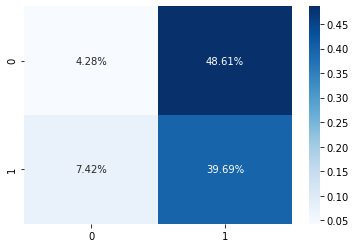

In [60]:
sns.heatmap(results/np.sum(results), annot=True, 
            fmt='.2%', cmap='Blues')
print(model.summary())

In [ ]:
import tensorflow as tf
print(tf.__version__)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.4):
      print("\nReached 60% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images/255.0
test_images=test_images/255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(training_images, training_labels, epochs=5, callbacks=[callbacks])
